In [37]:
from __future__ import print_function
import os
import neat

import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt



from explaneat.core.backprop import NeatNet
from explaneat.core import backprop
from explaneat.core.backproppop import BackpropPopulation
from explaneat.visualization import visualize
from explaneat.core.experiment import ExperimentReporter
from explaneat.core.utility import one_hot_encode


from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score



from copy import deepcopy

import time
from datetime import datetime


import gzip
try:
    import cPickle as pickle  # pylint: disable=import-error
except ImportError:
    import pickle  # pylint: disable=import-error

In [38]:

USE_CUDA = torch.cuda.is_available()
USE_CUDA = False
device = torch.device("cuda:1" if USE_CUDA else "cpu")
cuda_device = torch.device("cuda:1")

# Breast Cancer Experiment

This experiment (a) test the experimental environment, but is also to evaluate the efficacy of the ExplaNEAT algorithm. Speed is a critical factor, as well as stability of results on population size. Total run time will also be measured

First, we need to set a random seed and a total stopping point in the number of generations

In [3]:
my_random_seed = 42
random.seed(my_random_seed)

In [4]:
def one_hot_encode(vals):
    width = max(vals)
    newVals = []
    for val in vals:
        blank = [0. for _ in range(width + 1)]
        blank[val] = 1.
        newVals.append(blank)
    return np.asarray(newVals)


## Dataset

We are going to work with the Iris dataset, which will be loaded from `sklearn`. We want to characterise the efficacy of the algorithm with regards to a mostly untransformed dataset, so we will only normalise the features

In [5]:
# breast_cancer = datasets.load_breast_cancer()
breast_cancer = datasets.load_breast_cancer()
# breast_cancer = datasets.load_boston()
xs_raw = breast_cancer.data[:, :]
scaler = StandardScaler()
scaler.fit(xs_raw)
xs = scaler.transform(xs_raw)
ys = breast_cancer.target.astype(np.float32)
# ys_onehot = one_hot_encode(ys)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=69, random_state=42)

In [7]:
# # xs = torch.from_numpy(xs).to(device)
# # ys = torch.from_numpy(ys).to(device)
# X_train = torch.from_numpy(X_train).to(device)
# X_test = torch.from_numpy(X_test).to(device)
# y_train = torch.from_numpy(y_train).to(device)
# y_test = torch.from_numpy(y_test).to(device)

In [8]:
xs = torch.from_numpy(xs).to(device)
ys = torch.from_numpy(ys).to(device)

In [9]:
xs.shape

torch.Size([569, 30])

Let's have a look at the data we are working with

In [10]:
ys[18:23]

tensor([0., 1., 1., 1., 0.])

In [11]:
xs[18:20]

tensor([[ 1.6140,  0.6656,  1.5665,  1.7210,  0.1388, -0.0311,  0.7420,  1.1881,
         -0.8383, -1.2542,  1.2742, -0.3626,  1.4846,  1.5855, -0.1823, -0.3660,
          0.0669,  0.5538, -0.8454, -0.6801,  2.2884,  0.8472,  2.3691,  2.6675,
          0.8255,  0.3864,  1.2714,  1.8910, -0.2148, -0.4320],
        [-0.1668, -1.1472, -0.1857, -0.2520,  0.1017, -0.4369, -0.2782, -0.0286,
          0.2679, -0.7283, -0.4882, -0.7770, -0.4000, -0.3691,  0.4737, -0.6080,
         -0.2660,  0.2196, -0.0899, -0.5654, -0.2400, -1.0450, -0.2252, -0.2978,
          0.5099, -0.4896, -0.1592,  0.2161,  0.1233, -0.6293]],
       dtype=torch.float64)

## Performance metric

The NEAT implementation on which ExplaNEAT extends uses a single function call for evaluating fitness. Although this might be reworked for ExplaNEAT to be able to get consistency between the genome-evaluation and the backprop loss function, that can be reviewed later.

This use `Binary Cross Entropy Loss` from `PyTorch`

In [12]:
def eval_genomes(genomes, config):
    loss = nn.BCELoss()
    loss = loss.to(device)
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        preds = []
        for xi in X_train:
            preds.append(net.activate(xi))
        genome.fitness = float(1./loss(torch.tensor(preds).to(device), torch.tensor(y_train)))

## The competition

In [13]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);


In [14]:
# Use the forest's predict method on the test data
rf_preds = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_preds - y_test)

In [15]:
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.06


In [16]:
abs(rf_preds.round(0) - y_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [17]:
errors

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.186, 0.729,
       0.084, 0.121, 0.033, 0.032, 0.153, 0.006, 0.008, 0.027, 0.   ,
       0.   , 0.   , 0.794, 0.   , 0.   , 0.   , 0.   , 0.024, 0.   ,
       0.141, 0.   , 0.   , 0.003, 0.   , 0.248, 0.032, 0.   , 0.   ,
       0.233, 0.07 , 0.   , 0.102, 0.   , 0.   , 0.   , 0.   , 0.315,
       0.003, 0.184, 0.087, 0.001, 0.003, 0.01 , 0.   , 0.164, 0.065,
       0.   , 0.003, 0.   , 0.   , 0.23 , 0.   , 0.   , 0.   , 0.   ,
       0.027, 0.   , 0.053, 0.   , 0.   , 0.   ])

In [18]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,rf_preds.round(0)))

[[22  1]
 [ 1 45]]


In [19]:
roc_auc_score(y_test, rf_preds)

0.9971644612476371

## SVM

In [20]:
from sklearn.svm import SVC
svm_model=SVC()


In [21]:
svm_model.fit(X_train, y_train)
svm_preds=svm_model.predict(X_test)
# print(confusion_matrix(y_test,pred))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [22]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,svm_preds))

[[22  1]
 [ 0 46]]


In [23]:
print(confusion_matrix(y_train, svm_model.predict(X_train).round(0)))

[[183   6]
 [  1 310]]


In [24]:
roc_auc_score(y_test, svm_preds)

0.9782608695652174

# Regression

In [25]:
from sklearn.linear_model import LinearRegression
regression_model=LinearRegression()

In [26]:
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
regression_preds=regression_model.predict(X_test)

In [28]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,regression_preds.round(0)))

[[ 0  0  0]
 [ 1 20  2]
 [ 0  1 45]]


In [29]:
print(confusion_matrix(y_train, regression_model.predict(X_train).round(0)))

[[  0   0   0]
 [  1 170  18]
 [  0   0 311]]


In [30]:
roc_auc_score(y_test, regression_preds)

0.9886578449905481

# NNs

In [44]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_width=64):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_width) 
        self.fc2 = nn.Linear(hidden_width, hidden_width)
        self.fc3 = nn.Linear(hidden_width, hidden_width)
        self.fc4 = nn.Linear(hidden_width, hidden_width)
        self.fc5 = nn.Linear(hidden_width, output_size)  
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out
class TabularDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, xs, ys):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return (x, y)
    


In [45]:
batch_size = 1000
learning_rate = 0.0005
num_epochs = 200

In [46]:
X_train.shape

(500, 30)

In [47]:
y_train.shape

(500,)

In [49]:
train_data = TabularDataset(X_train, y_train)
train_loader = DataLoader(train_data, 
                           batch_size=batch_size, 
                           shuffle=True)

validate_data = TabularDataset(X_test, y_test)
validate_loader = DataLoader(dataset = validate_data,
                             batch_size=batch_size, 
                             shuffle=False)

total_step = len(train_loader)

my_random_seed = 42
random.seed(my_random_seed)
nn_model = NeuralNet(30, 1).to(cuda_device)

criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)  
for epoch in range(num_epochs):
    for i, (xsnn, ysnn) in enumerate(train_loader):  
        # Move tensors to the configured device
        xsnn = xsnn.float().to(cuda_device)
        ysnn = ysnn.view(-1, 1).float().to(cuda_device)

        # Forward pass
        outputs = nn_model(xsnn)
        train_loss = criterion(outputs, ysnn)
        

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, train_loss.item()))


Epoch [50/200], Step [1/1], Loss: 0.2157
Epoch [100/200], Step [1/1], Loss: 0.0379
Epoch [150/200], Step [1/1], Loss: 0.0135
Epoch [200/200], Step [1/1], Loss: 0.0028


In [50]:
nn_preds = torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()
nn_roc_score = roc_auc_score(y_test, nn_preds)
nn_roc_score

0.9896030245746692

## Explaneat

In [65]:
filePath = './../../data/experiments/breast-cancer/experiment-longepochsttsplit-10-1/fullStatus.xplnt'
with gzip.open(filePath, 'rb') as f: 
    data = pickle.load(f)     
    
p, g, ancestry, ancestors, randomState = data
config = p.config
bestNet = neat.nn.FeedForwardNetwork.create(g, config)

explaneat_preds = [bestNet.activate(x)[0] for x in X_test]

In [66]:
def calculate_max_depth(genome):
    connections = {}
    def my_depth(connections, ix):
        if ix < 0:
            return 0
        depths = []
        for c in connections[ix]:
            depths.append(my_depth(connections, c))
        return max(depths) + 1
                
    for key, conn in  genome.connections.items():
        if not key[1] in connections:
            connections[key[1]] = []
        connections[key[1]].append(key[0])
    all_depths = {}
    for c in connections:
        all_depths[c] = my_depth(connections, c)
    return all_depths
print("%s & %s & %s" % (g.size()[0]-1, g.size()[1], calculate_max_depth(g)[0]-1))
print(g.size())
print(calculate_max_depth(g))

5 & 32 & 3
(6, 32)
{0: 4, 243: 3, 302: 2, 652: 2, 1627: 1, 3388: 1}


In [67]:
print(g)

Key: 6998
Fitness: 27.788166046142578
Nodes:
	0 DefaultNodeGene(key=0, bias=0.6119692325592041, response=1.0, activation=sigmoid, aggregation=sum)
	243 DefaultNodeGene(key=243, bias=-0.12276055663824081, response=1.0, activation=sigmoid, aggregation=sum)
	302 DefaultNodeGene(key=302, bias=-0.41031524538993835, response=1.0, activation=sigmoid, aggregation=sum)
	652 DefaultNodeGene(key=652, bias=0.3694879710674286, response=1.0, activation=sigmoid, aggregation=sum)
	1627 DefaultNodeGene(key=1627, bias=-0.6460066437721252, response=1.0, activation=sigmoid, aggregation=sum)
	3388 DefaultNodeGene(key=3388, bias=0.8245570063591003, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-30, 0), weight=0.7125505805015564, enabled=True)
	DefaultConnectionGene(key=(-29, 0), weight=-0.3674076199531555, enabled=True)
	DefaultConnectionGene(key=(-28, 0), weight=-0.20707406103610992, enabled=True)
	DefaultConnectionGene(key=(-28, 302), weight=1.105614185333252,

In [64]:
g.size()

(6, 32)

In [73]:
config.genome_config.num_inputs

30

In [76]:
n_inputs = config.genome_config.num_inputs
checks = {-n: False for n in range(1, n_inputs+1)}

In [77]:
checks

{-1: False,
 -2: False,
 -3: False,
 -4: False,
 -5: False,
 -6: False,
 -7: False,
 -8: False,
 -9: False,
 -10: False,
 -11: False,
 -12: False,
 -13: False,
 -14: False,
 -15: False,
 -16: False,
 -17: False,
 -18: False,
 -19: False,
 -20: False,
 -21: False,
 -22: False,
 -23: False,
 -24: False,
 -25: False,
 -26: False,
 -27: False,
 -28: False,
 -29: False,
 -30: False}

In [85]:
def check_input_connections(genome, config):
    n_inputs = config.genome_config.num_inputs
    checks = {-n: False for n in range(1, n_inputs+1)}
    for c in genome.connections:
        if c[0] < 0:
            checks[c[0]] = True
    print(checks)
    mySum = 0
    for k, v in checks.items():
        if v: 
            mySum += 1
    return mySum
check_input_connections(g, config)

        

{-1: True, -2: True, -3: True, -4: True, -5: True, -6: False, -7: True, -8: True, -9: True, -10: True, -11: False, -12: False, -13: True, -14: True, -15: False, -16: False, -17: True, -18: False, -19: False, -20: False, -21: True, -22: True, -23: False, -24: False, -25: True, -26: False, -27: True, -28: True, -29: True, -30: True}


19

In [52]:
roc_auc_score(y_test, explaneat_preds)

0.9924385633270322

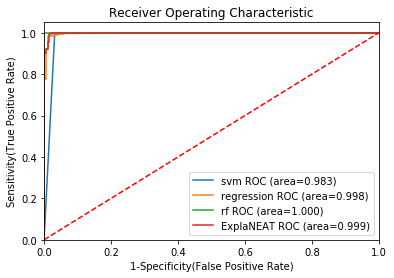

In [53]:
train_preds = {
    'svm': svm_model.predict(X_train),
    'regression': regression_model.predict(X_train),
    'rf': rf.predict(X_train),
    'ExplaNEAT': [bestNet.activate(x)[0] for x in X_train]
}

plt.figure()
for model, preds in train_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_train, preds)
    auc = metrics.roc_auc_score(y_train, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

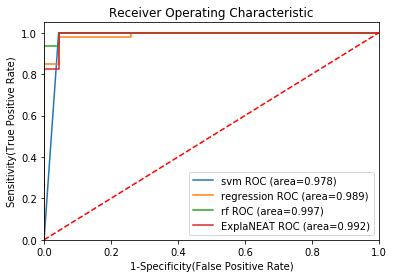

In [54]:
test_preds = {
    'svm': svm_model.predict(X_test),
    'regression': regression_model.predict(X_test),
    'rf': rf.predict(X_test),
    'ExplaNEAT': [bestNet.activate(x)[0] for x in X_test]
}

plt.figure()
for model, preds in test_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

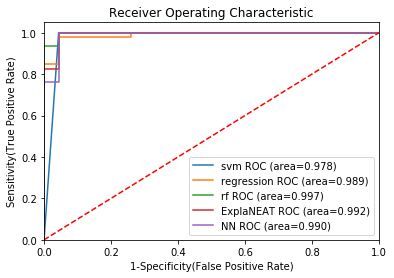

In [57]:
all_preds = {
    'svm': svm_preds,
    'regression': regression_preds,
    'rf': rf_preds,
    'ExplaNEAT': explaneat_preds,
    'NN': torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()
}

plt.figure()
for model, preds in all_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [58]:
for model, preds in all_preds.items():
    print(model)
    print(len(preds))
    print(metrics.roc_auc_score(y_test, preds))

svm
69
0.9782608695652174
regression
69
0.9886578449905481
rf
69
0.9971644612476371
ExplaNEAT
69
0.9924385633270322
NN
69
0.9896030245746692
